<a href="https://colab.research.google.com/github/XZHANG099/EE7403-Dimentionality-Reduction/blob/main/DimensionalityReduction_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction on LFW Dataset

In this notebook, we will demonstrate the use of PCA and LDA for dimensionality reduction on the LFW (Labeled Faces in the Wild) dataset. We will use the reduced features for classification using a Support Vector Machine (SVM) classifier.


## Import necesary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


## Define mahalanobis classifier used for PCA and LDA accuracy evaluation

In [4]:
def mahalanobis_classifier(X_train, y_train, X_test, y_test):
    unique_labels = np.unique(y_train)
    cov_matrices = {}
    means = {}
    cov_inv = {}

    # Calculate the class covariance matrices and mean values
    for label in unique_labels:
        data = X_train[y_train == label]
        cov_matrices[label] = np.cov(data.T)
        means[label] = np.mean(data, axis=0)
        cov_inv[label] = np.linalg.pinv(cov_matrices[label])

    # Perform classification using minimum Mahalanobis distance
    y_pred = []
    for x in X_test:
        distances = []
        for label in unique_labels:
            distance = mahalanobis(x, means[label], cov_inv[label])
            distances.append(distance)
        y_pred.append(unique_labels[np.argmin(distances)])

    return np.array(y_pred)

## Step 1: Dataset Importing and Preprocessing
* LFW dataset
  * grayscale images 
  * pre-labeled faces 
  * 250 x 250 pixels

In [5]:
# Pre processing
lfw_people = fetch_lfw_people(min_faces_per_person=25, resize=0.5)

X = lfw_people.data
y = lfw_people.target
n_classes = lfw_people.target_names.shape[0]
component = 30

print("Number of features:", X.shape[1])
print("Number of datasets (samples):", y.shape[0])
print("Number of classes: ", n_classes)

Number of features: 2914
Number of datasets (samples): 2588
Number of classes:  42


## Step 2: Dataset Splitting and Normalization
- Traning set: 80%
- Test set: 20%
- Randomlly shuffled before splitting
- Standard Scaler normalization

In [6]:
# Split training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Step 4: Dimensionality Reduction via PCA and LDA

In [26]:
# PCA
error_rates_pca = []
for n_components_pca in range(component, 1, -1):
    pca = PCA(n_components=n_components_pca, whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    y_pred_pca = mahalanobis_classifier(
        X_train_pca, y_train, X_test_pca, y_test)
    error_rate_pca = 1 - np.sum(y_pred_pca == y_test) / len(y_test)
    error_rates_pca.append(error_rate_pca)
    print(
        f"PCA Error Rate with {n_components_pca} components:", error_rate_pca)

# LDA
error_rates_lda = []
for n_components_lda in range(component, 1, -1):
    lda = LDA(n_components=n_components_lda)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    y_pred_lda = mahalanobis_classifier(
        X_train_lda, y_train, X_test_lda, y_test)
    error_rate_lda = 1 - np.sum(y_pred_lda == y_test) / len(y_test)
    error_rates_lda.append(error_rate_lda)
    print(
        f"LDA Error Rate with {n_components_lda} components:", error_rate_lda)


PCA Error Rate with 30 components: 0.7355212355212355
PCA Error Rate with 29 components: 0.7027027027027026
PCA Error Rate with 28 components: 0.6853281853281854
PCA Error Rate with 27 components: 0.6640926640926641
PCA Error Rate with 26 components: 0.6274131274131274
PCA Error Rate with 25 components: 0.611969111969112
PCA Error Rate with 24 components: 0.6061776061776062
PCA Error Rate with 23 components: 0.5907335907335907
PCA Error Rate with 22 components: 0.6061776061776062
PCA Error Rate with 21 components: 0.6061776061776062
PCA Error Rate with 20 components: 0.5965250965250966
PCA Error Rate with 19 components: 0.584942084942085
PCA Error Rate with 18 components: 0.583011583011583
PCA Error Rate with 17 components: 0.6023166023166023
PCA Error Rate with 16 components: 0.6003861003861004
PCA Error Rate with 15 components: 0.61003861003861
PCA Error Rate with 14 components: 0.6486486486486487
PCA Error Rate with 13 components: 0.667953667953668
PCA Error Rate with 12 components:

## Step 5: Applying SVM Model

In [27]:
# PCA
error_rates_pca_model = []
for n_components_pca in range(component, 1, -1):
    pca = PCA(n_components=n_components_pca, whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    # SVM on PCA-reduced data
    clf_pca = SVC(kernel='linear', C=1)
    clf_pca.fit(X_train_pca, y_train)
    y_pred_pca = clf_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    error_rate_pca_model = 1 - accuracy_pca
    error_rates_pca_model.append(error_rate_pca_model)
    print(
        f"PCA Model Error Rate with {n_components_pca} components:", error_rate_pca_model)

# LDA
error_rates_lda_model = []
for n_components_lda in range(component, 1, -1):
    lda = LDA(n_components=n_components_lda)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    # SVM on LDA-reduced data
    clf_lda = SVC(kernel='linear', C=1)
    clf_lda.fit(X_train_lda, y_train)
    y_pred_lda = clf_lda.predict(X_test_lda)
    accuracy_lda = accuracy_score(y_test, y_pred_lda)
    error_rate_lda_model = 1 - accuracy_lda
    error_rates_lda_model.append(error_rate_lda_model)
    print(
        f"LDA Model Error Rate with {n_components_lda} components:", error_rate_lda_model)

PCA Model Error Rate with 30 components: 0.4208494208494209
PCA Model Error Rate with 29 components: 0.4362934362934363
PCA Model Error Rate with 28 components: 0.44594594594594594
PCA Model Error Rate with 27 components: 0.4845559845559846
PCA Model Error Rate with 26 components: 0.48262548262548266
PCA Model Error Rate with 25 components: 0.4942084942084942
PCA Model Error Rate with 24 components: 0.5115830115830116
PCA Model Error Rate with 23 components: 0.5135135135135135
PCA Model Error Rate with 22 components: 0.5540540540540541
PCA Model Error Rate with 21 components: 0.5444015444015444
PCA Model Error Rate with 20 components: 0.5617760617760618
PCA Model Error Rate with 19 components: 0.5501930501930502
PCA Model Error Rate with 18 components: 0.5617760617760618
PCA Model Error Rate with 17 components: 0.5617760617760618
PCA Model Error Rate with 16 components: 0.5521235521235521
PCA Model Error Rate with 15 components: 0.5694980694980696
PCA Model Error Rate with 14 component

## Train and evaluate a Support Vector Machine (SVM) classifier

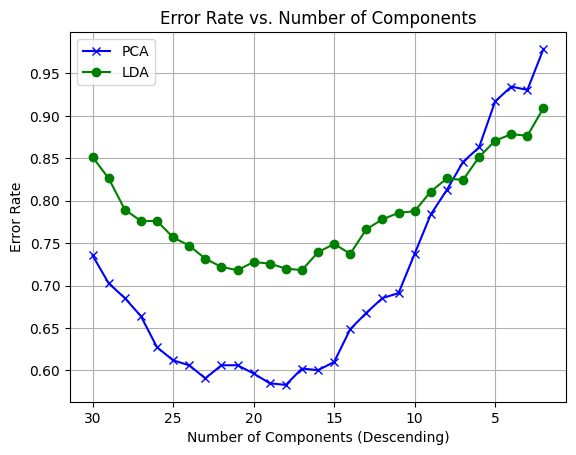

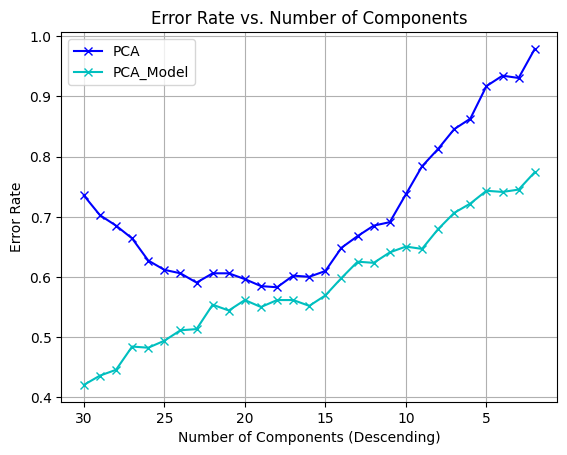

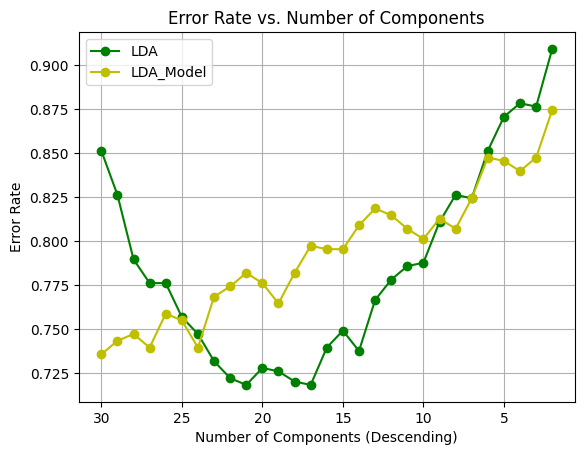

In [29]:
# Plot the accuracies
plt.plot(range(component, 1, -1), error_rates_pca, marker='x', color='b', label='PCA')
plt.plot(range(component, 1, -1), error_rates_lda, marker='o', color='g', label='LDA')
plt.xlabel('Number of Components (Descending)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Components')
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
plt.show()

# Plot the accuracies
plt.plot(range(component, 1, -1), error_rates_pca, marker='x', color='b', label='PCA')
plt.plot(range(component, 1, -1), error_rates_pca_model, marker='x', color='c', label='PCA_Model')
plt.xlabel('Number of Components (Descending)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Components')
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
plt.show()

# Plot the accuracies
plt.plot(range(component, 1, -1), error_rates_lda, marker='o', color='g', label='LDA')
plt.plot(range(component, 1, -1), error_rates_lda_model, marker='o', color='y', label='LDA_Model')
plt.xlabel('Number of Components (Descending)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Components')
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
plt.show()



---

